**idea: combine rf regressor (for short term trends) and lstm(for long term trends)**

In [13]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt 

In [2]:
path = r'C:\Users\User\dev\training_model\dataset\modified_financial_data.csv'
df = pd.read_csv(path)

df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

df.columns

Index(['^GSPC', 'GLD', 'USO', 'SLV', 'EURUSD=X', 'Date'], dtype='object')

In [3]:
df = df.rename(columns={"^GSPC": "SPX", "EURUSD=X": "EUR/USD"})

df.head()

,SPX,GLD,USO,SLV,EUR/USD,Date
0,2058.199951,114.080002,159.119995,15.11,1.208941,2015-01-02
1,2020.579956,115.800003,150.320007,15.50,1.194643,2015-01-05
2,2002.609985,117.120003,144.399994,15.83,1.193902,2015-01-06
3,2025.900024,116.430000,146.960007,15.85,1.187536,2015-01-07
4,2062.139893,115.940002,148.399994,15.64,1.183600,2015-01-08


In [4]:
features = ['SPX', 'USO', 'SLV', 'EUR/USD']  
target = 'GLD'

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_X.fit_transform(df[features])
y = scaler_y.fit_transform(df[[target]])

df_scaled = pd.DataFrame(X, columns=features)
df_scaled[target] = y

In [5]:
split_index = int(len(X) * 0.8)
X_train_rf, X_test_rf = X[:split_index], X[split_index:]
y_train_rf, y_test_rf = y[:split_index], y[split_index:]

rf = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)
rf.fit(X_train_rf, y_train_rf.ravel())

rf_preds = rf.predict(X_test_rf)

c:\Users\User\dev\training_model\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [6]:
def create_sequences(data, target_column, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data.iloc[i-n_steps:i].values)
        y.append(data.iloc[i][target_column])
    return np.array(X), np.array(y)

In [7]:
n_steps = 10
lstm_data = df_scaled.copy()
X_lstm, y_lstm = create_sequences(lstm_data, target, n_steps)

X_train_lstm, X_test_lstm = X_lstm[:split_index - n_steps], X_lstm[split_index - n_steps:]
y_train_lstm, y_test_lstm = y_lstm[:split_index - n_steps], y_lstm[split_index - n_steps:]

# LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=False, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=16, verbose=0)

lstm_preds = model_lstm.predict(X_test_lstm)

c:\Users\User\dev\training_model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [ ]:
min_len = min(len(rf_preds), len(lstm_preds))
rf_preds = rf_preds[-min_len:]
lstm_preds = lstm_preds[-min_len:]
y_true = y_test_rf[-min_len:]


combined_preds = (rf_preds + lstm_preds.ravel()) / 2

In [10]:
meta_X = np.column_stack((rf_preds, lstm_preds.ravel()))
meta_y = y_true

meta_model = LinearRegression()
meta_model.fit(meta_X, meta_y)
final_preds = meta_model.predict(meta_X)

In [12]:
print("R² Score (Ensemble):", r2_score(y_true, combined_preds))
print("MSE (Ensemble):", mean_squared_error(y_true, combined_preds))


R² Score (Ensemble): 0.5216862087689211
MSE (Ensemble): 0.012366716200430512


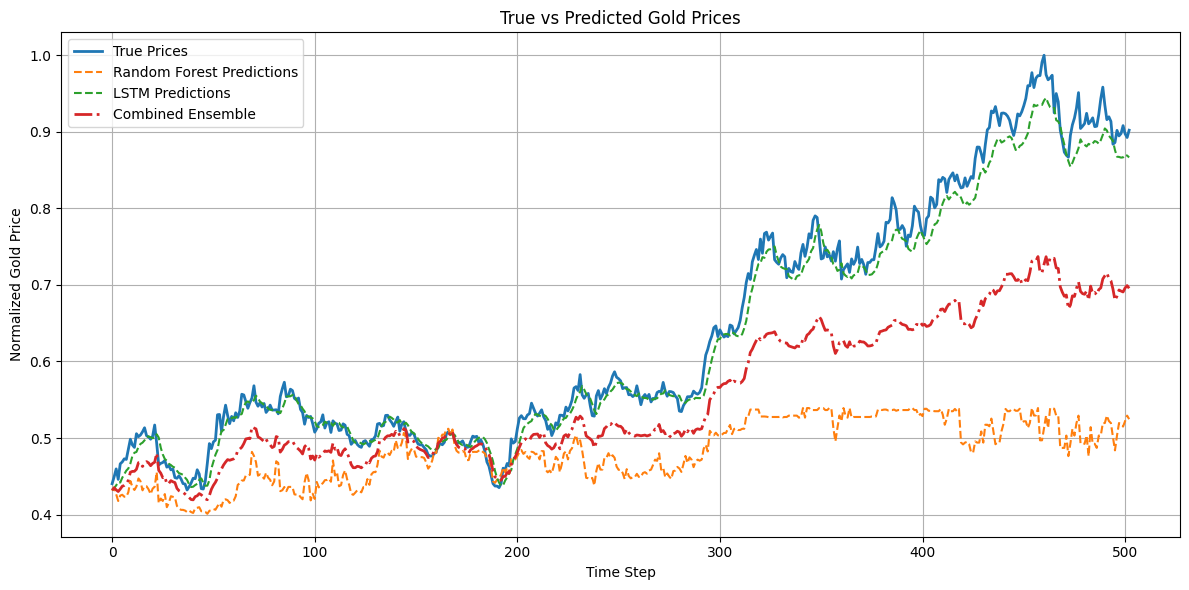

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='True Prices', linewidth=2)
plt.plot(rf_preds, label='Random Forest Predictions', linestyle='--')
plt.plot(lstm_preds, label='LSTM Predictions', linestyle='--')
plt.plot(combined_preds, label='Combined Ensemble', linestyle='-.', linewidth=2)

plt.title('True vs Predicted Gold Prices')
plt.xlabel('Time Step')
plt.ylabel('Normalized Gold Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()